In [355]:
import pandas as pd
from context import Visualizer
from strategies import * 
from data_extractor import Extractor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import matplotlib as mpl
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap

In [23]:
data = Extractor()
races = data.races
circuits = data.circuits
drivers = data.drivers
lap_times = data.lap_times
qualifying = data.qualifying
results = data.results

In [108]:
def equalize_lengt(input_dict):
    maxlen = max(len(x) for x in input_dict.values())
    for key, value in input_dict.items():
        diff = maxlen - len(value)
        input_dict[key] += [np.nan] * diff

def switch_driver_id(input_dict):
    out = {}
    for key, value in input_dict.items():
        driver = drivers[drivers["driverId"] == key].driverRef.iloc[0]
        out[driver] = value
    return out

def doc(o):
    print(o.__doc__)
    
def str_to_sec(time_str):
    s = time_str.split(":")
    out = 0
    for exp, elem in enumerate(reversed(s)):
        out += float(elem) * (60**exp)
    return out

def mae(y_true, y_pred):
    return np.abs(y_true - y_pred).mean()

current_drivers = results[results["raceId"] == 1052].driverId.unique()

In [29]:
for driv in current_drivers:
    print(driv, ": ", drivers[drivers["driverId"] == driv].driverRef.iloc[0], sep="")

1: hamilton
830: max_verstappen
822: bottas
846: norris
815: perez
844: leclerc
817: ricciardo
832: sainz
852: tsunoda
840: stroll
8: raikkonen
841: giovinazzi
839: ocon
847: russell
20: vettel
854: mick_schumacher
842: gasly
849: latifi
4: alonso
853: mazepin


In [30]:
ham_ver_bot = [1, 830, 822]

In [304]:
dfs = []
race_ids = []
for driv in ham_ver_bot:
    dfs.append(results[results["driverId"] == driv])
    #dfs.append(qualifying[qualifying["driverId"] == driv])
    race_ids += list(results[results["driverId"] == driv].raceId)
    
valid_race_ids = set()
for race_id in race_ids:
    if race_ids.count(race_id) == len(ham_ver_bot):
        valid_race_ids.add(race_id)
        
for i, df in enumerate(dfs):
    dfs[i] = df[df["raceId"].isin(valid_race_ids)]

In [318]:
res, qual = {driver_id:[] for driver_id in ham_ver_bot}, {driver_id:[] for driver_id in ham_ver_bot}
for i, df in enumerate(dfs):
    for idx, row in df.iterrows():
        res[row.driverId].append(row.positionOrder)
        qual[row.driverId].append(row.grid)

res = switch_driver_id(res)
qual = switch_driver_id(qual)
for key in qual.keys():
    res[key + "_qualifying"] = qual[key]
res_df = pd.DataFrame(res)

inputs_columns = [i for i in res_df.columns if "qualifying" in i]
inputs = res_df[inputs_columns]
X_train, X_test, y_train, y_test = train_test_split(inputs.values, res_df["hamilton"].values, test_size=0.2, random_state=0) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test) 
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

print(X_test)
print(y_pred)
mae(y_pred, y_test)

Number of mislabeled points out of a total 24 points : 14
[[ 8  5  1]
 [ 2 19  3]
 [ 2  4  5]
 [ 1 13  4]
 [ 4  5  3]
 [10  9  2]
 [ 1  7  6]
 [ 1 18  3]
 [13  4  3]
 [ 4  2  3]
 [ 3  4 10]
 [ 4  5  3]
 [ 1 13  5]
 [ 1  4 15]
 [ 2  1  3]
 [ 1  2  4]
 [ 2  4  7]
 [ 4  7  3]
 [ 1  2  3]
 [ 1  3  2]
 [ 2  5  3]
 [ 2  6  1]
 [ 2  8  6]
 [ 3  0 10]]
[5 1 1 1 1 7 1 1 7 9 2 1 1 2 1 9 1 1 9 1 1 1 1 1]


1.7083333333333333

In [310]:
results_df = results.merge(races, on="raceId", how="left")
driver_results = [results_df[results_df["driverId"] == driver_id][["driverId", "circuitId", "grid", "positionOrder"]] for driver_id in current_drivers]
train_df = pd.concat(driver_results)

X_train, X_test, y_train, y_test = train_test_split(train_df[train_df.columns[:-1]].values, train_df["positionOrder"].values, test_size=0.2) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test) 
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print(mae(y_pred, y_test))
diffs = np.abs(y_pred - y_test)
print(diffs.std())

Number of mislabeled points out of a total 474 points : 429
5.544303797468355
5.770865575821793


In [320]:
curr_df = results_df[["circuitId", "grid", "positionOrder"]]
X_train, X_test, y_train, y_test = train_test_split(curr_df[curr_df.columns[:-1]].values, curr_df["positionOrder"].values, test_size=0.2) 
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test) 
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
mae(y_pred, y_test)
np.corrcoef(curr_df["grid"], curr_df["positionOrder"])

Number of mislabeled points out of a total 4996 points : 4594


array([[1.        , 0.14579416],
       [0.14579416, 1.        ]])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


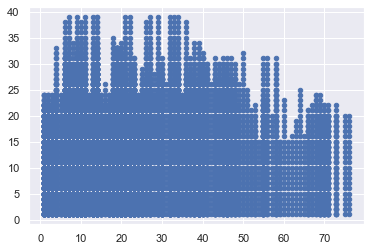

In [286]:
v = Visualizer()
v.strategy = ScatterPlotter()
v.plot(curr_df, columns=["circuitId", "positionOrder"])

0.1540084388185654
4.5
4.9755732447552266


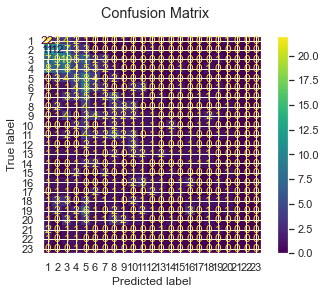

In [356]:
classifier = svm.SVC(gamma=0.1)
X_train, X_test, y_train, y_test = train_test_split(train_df[train_df.columns[:-1]].values, train_df["positionOrder"].values, test_size=0.2) 
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
print(accuracy_score(predicted, y_test))
print(mae(predicted, y_test))
print(np.abs(predicted - y_test).std())
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

In [349]:
accuracy_score(predicted, y_test)

0.13291139240506328

In [300]:
x = test_df[test_df["driverId"] == 1]
x1, x2, y1, y2 = train_test_split(x[x.columns[:-1]].values, x["positionOrder"].values, test_size=0.2, random_state=0)
model = GaussianNB()
model.fit(x1, y1)
pred = model.predict(x2)
print(x2, y2)

print(mae(pred, y2))
print(pred)
print(y2)
print([np.argmax(i) for i in model.predict_proba(x2)])

[[ 1 14  1]
 [ 1 17  3]
 [ 1  7  4]
 [ 1  9  4]
 [ 1 75  1]
 [ 1 34  1]
 [ 1  7  2]
 [ 1 17  7]
 [ 1 15  5]
 [ 1 12  1]
 [ 1 70  5]
 [ 1  7  1]
 [ 1 15  5]
 [ 1  7  1]
 [ 1  3  9]
 [ 1 16  1]
 [ 1 18  2]
 [ 1 22  2]
 [ 1  4  2]
 [ 1 17  6]
 [ 1 13  1]
 [ 1 18 20]
 [ 1 14  3]
 [ 1  8 13]
 [ 1  7  2]
 [ 1 22  3]
 [ 1  1  3]
 [ 1 24  1]
 [ 1  6  1]
 [ 1 32  3]
 [ 1 70  9]
 [ 1  4  2]
 [ 1 22  4]
 [ 1 13  7]
 [ 1 20 10]
 [ 1 69  2]
 [ 1 17  4]
 [ 1 17  9]
 [ 1 71  2]
 [ 1  3  2]
 [ 1 69  1]
 [ 1 15  1]
 [ 1  6  9]
 [ 1 71  1]
 [ 1  2  1]
 [ 1  6  3]
 [ 1  6  2]
 [ 1  3  2]
 [ 1 13  2]
 [ 1 13  1]
 [ 1  7  2]
 [ 1 14  1]
 [ 1 11  5]
 [ 1  6  1]] [ 2  1  5  1  1  1  1  3  1  2  4  1 18  1  3 12  2  1  2  2  1  4  1 10
 17 20  5  1  3  1  2  1  3 23  9  1  4  6  1  2  1  1  6  3 18  1  2  2
  1  3  3  1 20  1]
7.0
[21  1  1  1  1 21  1  3  1 21  4 21  1 21 13 21  1  1  1  3 21  3  1  3
  1  1  1 21 21  1  5  1  1  3  3  1  1  3  1  1  1 21  3  1 21  1  1  1
  1 21  1 21 24 21]
[ 2  1  5  1  1

In [265]:
np.bincount(y1)

array([ 0, 74, 31, 23, 18, 17,  4,  9,  4,  5,  1,  0,  3,  2,  1,  0,  2,
        0,  1,  8,  2,  2,  2,  1,  3], dtype=int64)

positionOrder


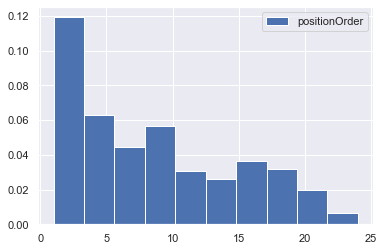

In [187]:
c = Visualizer()
c.strategy = HistogramPlotter()
c.plot(test_df, columns=["positionOrder"])

In [197]:
a = np.bincount(test_df["positionOrder"].values) / len(test_df) 
means = np.array([test_df[test_df["positionOrder"] == pos]["grid"].mean() for pos in range(1, 25)])
stds = np.array([test_df[test_df["positionOrder"] == pos]["grid"].std() for pos in range(1, 25)])

In [218]:
means = np.array([test_df[test_df["positionOrder"] == pos]["grid"].mean() for pos in range(1, 25)])
stds = np.array([test_df[test_df["positionOrder"] == pos]["grid"].std() for pos in range(1, 25)])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0    hamilton
Name: driverRef, dtype: object


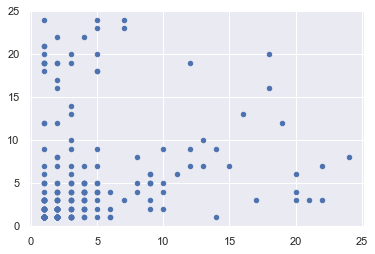

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


829    max_verstappen
Name: driverRef, dtype: object


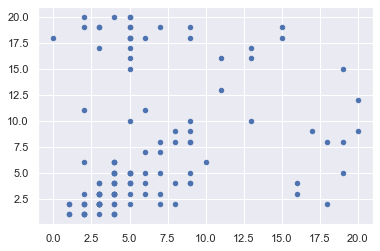

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


821    bottas
Name: driverRef, dtype: object


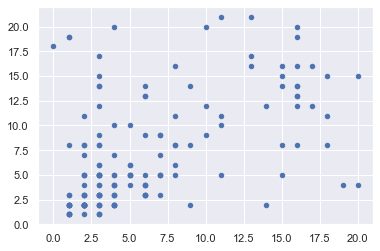

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


844    norris
Name: driverRef, dtype: object


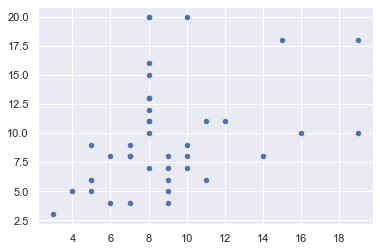

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


814    perez
Name: driverRef, dtype: object


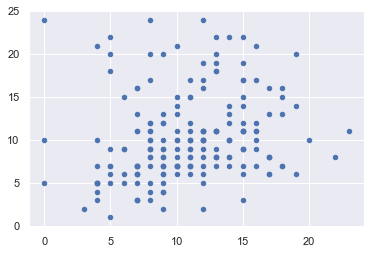

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


842    leclerc
Name: driverRef, dtype: object


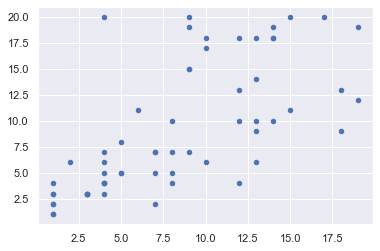

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


816    ricciardo
Name: driverRef, dtype: object


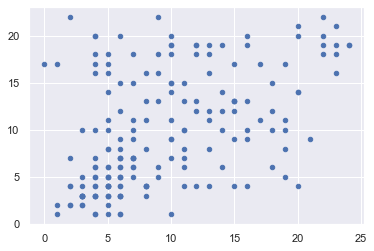

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


831    sainz
Name: driverRef, dtype: object


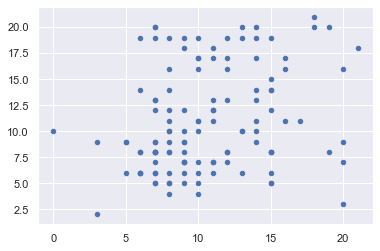

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


850    tsunoda
Name: driverRef, dtype: object


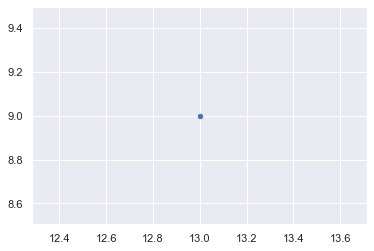

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


839    stroll
Name: driverRef, dtype: object


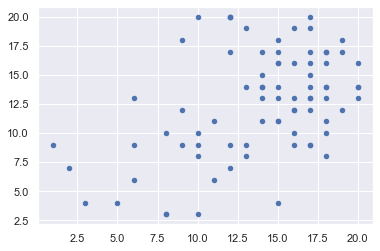

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


7    raikkonen
Name: driverRef, dtype: object


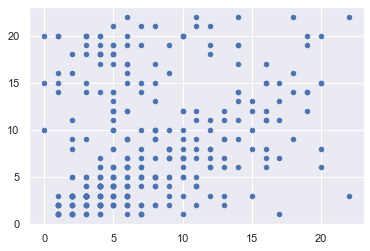

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


840    giovinazzi
Name: driverRef, dtype: object


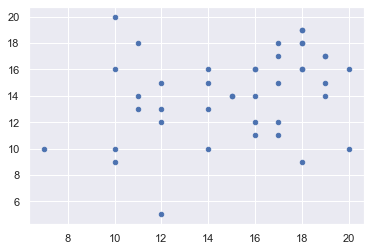

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


838    ocon
Name: driverRef, dtype: object


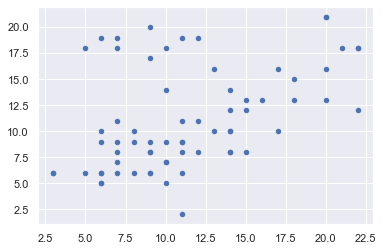

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


845    russell
Name: driverRef, dtype: object


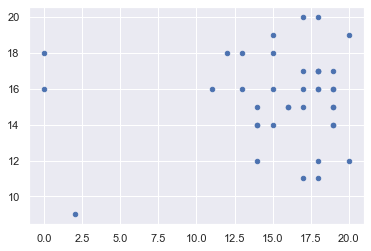

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


19    vettel
Name: driverRef, dtype: object


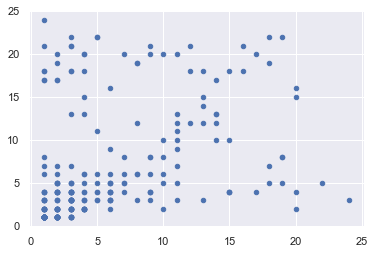

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


852    mick_schumacher
Name: driverRef, dtype: object


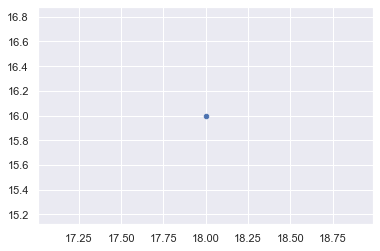

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


452    gasly
Name: driverRef, dtype: object


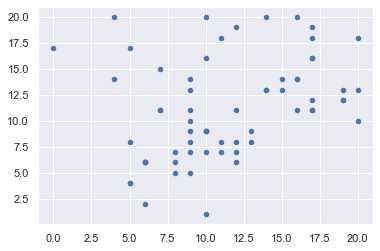

847    latifi
Name: driverRef, dtype: object


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


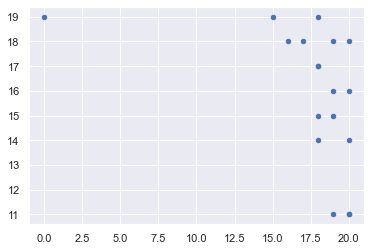

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


3    alonso
Name: driverRef, dtype: object


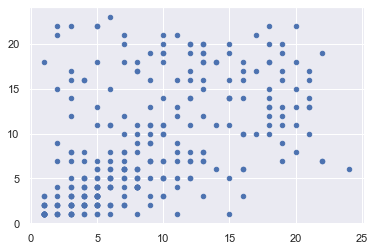

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


851    mazepin
Name: driverRef, dtype: object


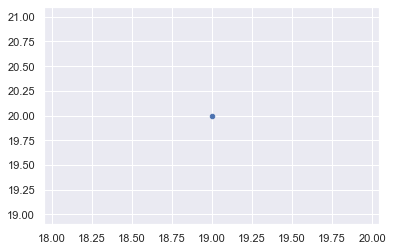

In [313]:
c = Visualizer()
c.strategy = ScatterPlotter()
for driver_id in current_drivers:
    print(drivers[drivers["driverId"] == driver_id].driverRef)
    c.plot(test_df[test_df["driverId"] == driver_id], columns=["grid", "positionOrder"])
    plt.show()

In [219]:
stds

array([2.31217482, 2.87492756, 4.16497081, 4.01277173, 3.76034665,
       4.29825012, 4.48616763, 4.93009605, 4.51792166, 4.70847167,
       4.59232547, 5.14893596, 4.76364771, 5.28142548, 5.80526725,
       5.65530336, 6.22838453, 6.33583047, 6.1678892 , 5.7648627 ,
       6.55087942, 7.04745817, 1.        , 4.45078912])

In [220]:
asd = test_df[test_df["driverId"] == 1]
b = np.bincount(asd["positionOrder"].values) / len(asd) 
m = np.array([asd[asd["positionOrder"] == pos]["grid"].mean() for pos in range(1, 25)])
st = np.array([asd[asd["positionOrder"] == pos]["grid"].std() for pos in range(1, 25)])


array([0.        , 0.35955056, 0.14981273, 0.11235955, 0.07865169,
       0.07116105, 0.02247191, 0.03370787, 0.01498127, 0.02247191,
       0.00749064, 0.        , 0.01498127, 0.00749064, 0.00374532,
       0.        , 0.00749064, 0.00374532, 0.01123596, 0.02996255,
       0.01498127, 0.00749064, 0.00749064, 0.00749064, 0.01123596])

array([ 1.75      ,  2.55      ,  4.96666667,  4.80952381,  4.57894737,
        8.83333333,  8.55555556,  9.        ,  7.5       ,  8.        ,
               nan,  5.75      ,  9.5       ,  3.        ,         nan,
       10.        ,  2.        ,  3.66666667,  2.875     ,  6.75      ,
        1.        ,  3.        ,  6.        ,  4.33333333])

array([ 1.62869014,  2.01214263,  6.32173772,  4.05732729,  2.98730256,
        6.70571895,  7.23033732, 10.39230485,  5.24404424,  7.07106781,
               nan,  8.84590301,  9.19238816,         nan,         nan,
       11.3137085 ,         nan,  2.30940108,  3.75832409,  7.67571929,
        0.        ,  1.41421356,  1.41421356,  3.05505046])

In [239]:
dummy_in = []
classes = []

for i in range(1000):
    for j in range(3):
        classes.append(j)
        dummy_in.append([999 + j, np.random.rand() + j])
        if 999 + j == 1000:
dummy_in = np.array(dummy_in)
classes = np.array(classes)
        

In [228]:
dummy_in.shape

(3, 2, 1000)

In [236]:
np.concatenate([[[1000] * 1000, np.random.rand(1000)], [[1000] * 1000, np.random.rand(1000)]]).shape

(4, 1000)

In [259]:
nb = GaussianNB()
x1, x2, y1, y2 = train_test_split(dummy_in, classes, test_size=0.2)
nb.fit(x1, y1)
p = nb.predict(x2)
doc(nb)


    Gaussian Naive Bayes (GaussianNB)

    Can perform online updates to model parameters via :meth:`partial_fit`.
    For details on algorithm used to update feature means and variance online,
    see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:

        http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf

    Read more in the :ref:`User Guide <gaussian_naive_bayes>`.

    Parameters
    ----------
    priors : array-like of shape (n_classes,)
        Prior probabilities of the classes. If specified the priors are not
        adjusted according to the data.

    var_smoothing : float, default=1e-9
        Portion of the largest variance of all features that is added to
        variances for calculation stability.

        .. versionadded:: 0.20

    Attributes
    ----------
    class_count_ : ndarray of shape (n_classes,)
        number of training samples observed in each class.

    class_prior_ : ndarray of shape (n_classes,)
        probab

In [245]:
y2

array([2, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       1, 2, 2, 0, 2, 1, 1, 2, 2, 0, 1, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2,
       2, 1, 0, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 1, 2, 0, 1, 2, 2, 1,
       2, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 1,
       1, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 2, 1,
       1, 0, 2, 2, 1, 0, 0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 2, 2, 0,
       2, 1, 1, 0, 2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 2, 2, 0, 1, 2, 1, 1,
       1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 2, 2, 2, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 0, 2,
       2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 2, 0, 2, 0, 1, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 0, 2, 1, 2, 0, 1, 0,
       2, 2, 1, 1, 0, 1, 1, 1, 2, 0, 2, 1, 1, 0, 1,

In [322]:
train_df

,driverId,circuitId,grid,positionOrder
0,1,1,1,1
26,1,2,9,5
56,1,3,3,13
68,1,4,5,3
89,1,5,3,2
...,...,...,...,...
24156,4,32,12,20
24173,4,18,17,17
24187,4,24,15,11
24978,4,3,9,19


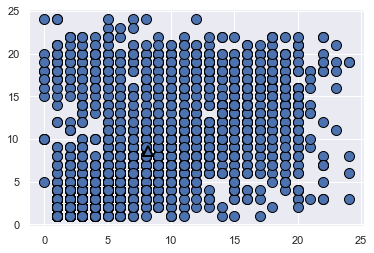

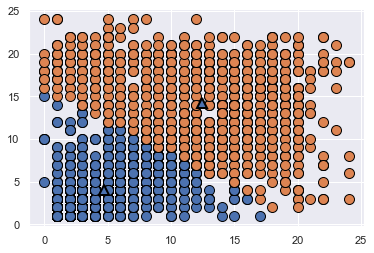

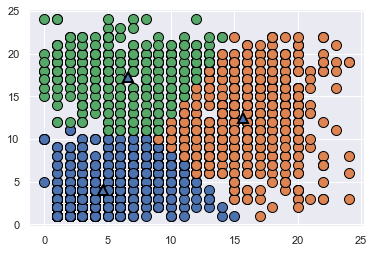

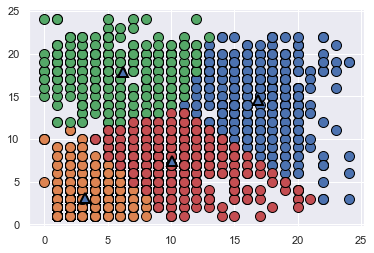

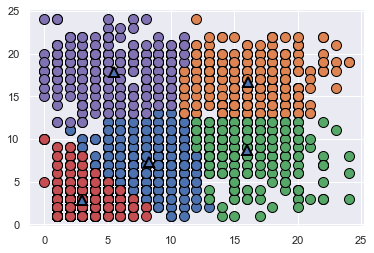

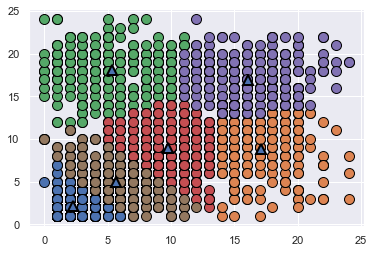

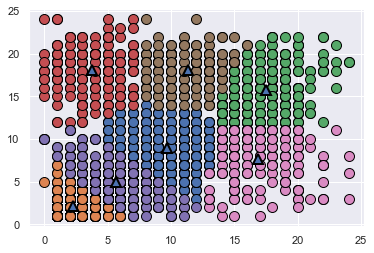

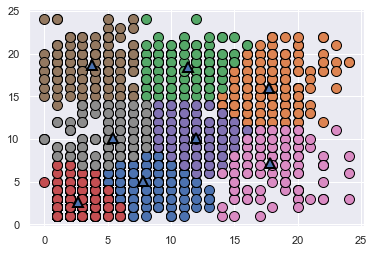

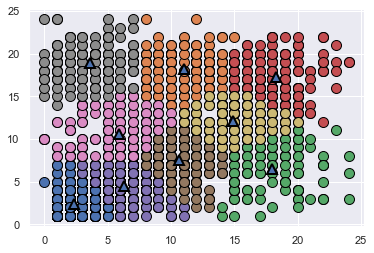

In [341]:
nclusters = 10
X = train_df[["grid", "positionOrder"]].values
for i in range(1, nclusters):
    # build the clustering model
    kmeans = KMeans(n_clusters=i)  # i - clusters
    
    kmeans.fit(X)
    cols = nclusters / 2
    pos = 200 + 10 * cols + i
    #plt.subplot(int(pos))
    # The cluster centers are stored in thecluster_centers_ attribute, and we plot them as triangles
    discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o')
    discrete_scatter(
        kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
    #    range(len(kmeans.cluster_centers_)), 
        markers='^', markeredgewidth=2)
    plt.show()



In [327]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.

    Parameters
    ----------

    x1 : nd-array
        input data, first axis

    x2 : nd-array
        input data, second axis

    y : nd-array
        input data, discrete labels

    cmap : colormap
        Colormap to use.

    markers : list of string
        List of markers to use, or None (which defaults to 'o').

    s : int or float
        Size of the marker

    padding : float
        Fraction of the dataset range to use for padding the axes.

    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))
    return lines

In [335]:
doc(kmeans)

K-Means clustering.

    Read more in the :ref:`User Guide <k_means>`.

    Parameters
    ----------

    n_clusters : int, default=8
        The number of clusters to form as well as the number of
        centroids to generate.

    init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
        Method for initialization:

        'k-means++' : selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence. See section
        Notes in k_init for more details.

        'random': choose `n_clusters` observations (rows) at random from data
        for the initial centroids.

        If an array is passed, it should be of shape (n_clusters, n_features)
        and gives the initial centers.

        If a callable is passed, it should take arguments X, n_clusters and a
        random state and return an initialization.

    n_init : int, default=10
        Number of time the k-means al

In [336]:
dir(kmeans)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algorithm',
 '_check_mkl_vcomp',
 '_check_n_features',
 '_check_params',
 '_check_test_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_init_centroids',
 '_more_tags',
 '_n_init',
 '_n_threads',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tol',
 '_transform',
 '_validate_center_shape',
 '_validate_data',
 'algorithm',
 'cluster_centers_',
 'copy_x',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inertia_',
 'init',
 'labels_',
 'max_iter',
 'n_clusters',
 'n_features_in_',
 'n_init',
 'n_iter_',
 'n_jobs',
 'precompute_distances',
 'predict'

In [339]:
kmeans.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 9,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}